# Project Notebook
##### Created by Dario Sandrucci 48436

bla bla bla

### 0. Import Packages

In [41]:
from data_engineering import *
from denoising_and_detoning import *
from algorithm import *
from portfolio_and_backtesting import *

### 1. Data Preparation and Exploration

##### 1.1 Loading Data

Let import return data from S&P 500 stocks over the period of approximately the last 10 years.

In [ ]:
tickers = getTickers()
end = dt.now()
start = dt.fromisoformat('2017-11-17')
df = getData(start, end, tickers, downloaded = True)

Data was loaded sucessfully!


##### 1.2 Data Visualization

A chart the shows the percentage returns over the period of the sample.

In [ ]:
ax = df.plot(legend=False, figsize=(20,10))
ax.set_ylabel('percentage returns')
ax.set_title('Log Returns of S&P500 Stocks for Training Period')

A chart to show the cummulative returns of the SPY index over the data period.

In [ ]:
spy_returns = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
spy_returns = spy_returns.pct_change().dropna(axis = 0)
spy_cum = np.cumprod(1 + spy_returns) - 1
spy_cum.columns = ["S&P 500 Index"]

ax = spy_cum.plot(legend=False, figsize=(8,5))
ax.set_ylabel('cumulative returns')
ax.set_title('Cummulative returns of the S&P 500 Index over the period of the data set')

##### 1.3 Data Transformation

We will split the set into train and test set.

In [ ]:
train_set, test_set = testTrainSplit(df, validation_set = False, w_tt = [0.8, 0.2])

Now lets derive the empirical correlation matrix of our return data.

In [ ]:
corr0 = pd.DataFrame(getCorrMatrix(train_set), index = train_set.columns, columns = train_set.columns )

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr0)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr0, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

### 2. Denoise and Detone the Empirical correlation Matrix

Lets denoise the correlation matrix.

In [ ]:
eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr1)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr1, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

Next lets detone the correlation matrix.

In [ ]:
corr2 = detoneMatrix(corr1, eVal1, eVec1)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr2)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr2, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

In [ ]:
def denoise_and_detone(rets):
    corr0 = getCorrMatrix(rets)
    eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)
    corr2 = detoneMatrix(corr1, eVal1, eVec1)
    return corr2

## 3. Distance Metrics

We will use the mikowski distance metric. Our denoised and detoned correlation matrix is transformed accordingly.

In [ ]:
from sklearn.metrics import pairwise_distances

Now lets create our 11 distance matricies with our p values.

In [ ]:
min_matrix = np.array(pairwise_distances(corr2, metric = "minkowski"))

## 3. Portfolio Construction

#### 3.1 Clustering

##### 3.1.1 Finding the number of clusters

Our first method is the Elbow method

In [ ]:
nr_clusters_sse = sse(min_matricies[10])

Now lets try the Silhouette method

In [ ]:
nr_clusters_sil = sil_score(min_matrix)

Our last method is the Davies-Boulding Score

In [ ]:
nr_clusters_db = db_score(min_matrix)

We will use the median number of clusters for for Kmeans.

##### 3.1.2 Running the clustering algorithm

In [ ]:
w = optPort_nco(train_set, min_matrix, 3, 0.074, 50, 5)

## 4. Perfromance evaluation

#### 4.1. Benchmarking

##### 4.1.1 Distance metric tuning

Lets define possible p values for out minkoswki distance metric.

In [ ]:
ps = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]

Now lets try out:

In [ ]:
def p_tuner(train_set, corr, th = 0.074, iter = 1000):
    min_ports = []
    ps = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
    for p in tqdm(ps):
        min_matrix_ = np.array(pairwise_distances(corr, metric = "minkowski", p = p))
        nr_clusters_sse = sse(min_matrix_, graph = False)
        w_ = optPort_nco(train_set, min_matrix_, nr_clusters_sse, th, iter, 5)
        name = f"P = {p}; C = {nr_clusters_sse}"
        port = Portfolio(name, test_set, w_)
        min_ports.append(port)
    return min_ports

In [ ]:
min_ports = p_tuner(train_set, corr2)
min_bm = PortfolioBenchmarking(min_ports)

In [ ]:
rp = min_bm.performance_report(True)

/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [ ]:
rp

,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
SPY,-0.1403,0.2408,0.0000,0.2817,1.0000,-0.5829,-0.9325,0.0000,-0.0753
P = 1.0; C = 3,-0.0314,0.2786,0.0005,0.2824,1.0637,-0.1126,-0.1828,0.9911,-0.0853
P = 1.1; C = 3,-0.0228,0.2805,0.0005,0.3056,1.0497,-0.0811,-0.1314,0.9693,-0.0857
P = 1.2; C = 3,-0.0175,0.2862,0.0005,0.2906,1.0687,-0.0611,-0.0991,0.9785,-0.0880
P = 1.3; C = 3,0.0032,0.2870,0.0006,0.2404,1.0633,0.0112,0.0181,1.1060,-0.0901
P = 1.4; C = 3,-0.0205,0.2892,0.0005,0.2846,1.0863,-0.0708,-0.1139,0.9654,-0.0883
P = 1.5; C = 3,0.0268,0.2819,0.0007,0.1877,1.0380,0.0949,0.1522,1.2830,-0.0882
P = 1.6; C = 3,-0.0244,0.2886,0.0005,0.3035,1.0822,-0.0846,-0.1364,0.9309,-0.0877
P = 1.7; C = 3,-0.0065,0.2838,0.0006,0.2779,1.0486,-0.0229,-0.0370,1.0356,-0.0887
P = 1.8; C = 3,0.0057,0.2877,0.0006,0.2347,1.0653,0.0197,0.0315,1.1180,-0.0896


Now lets find out if the p value has statistical seginificance on the performance metrics.

In [ ]:
significance = {}

for m in rp.columns:
    pvalue_beta = round(regression(ps, rp.iloc[1:].loc[:,m].values)[4],4)
    significance[m] = pvalue_beta

In [ ]:
significance

{'ARet': 0.0173,
 'AVol': 0.019,
 'Alpha': 0.0173,
 'p Alpha': 0.0841,
 'Beta': 0.0198,
 'Sharpe': 0.0155,
 'Sortino': 0.0163,
 'IR': 0.0684,
 'MDD': 0.0004}

##### 4.1.2 Clustering vs general portfolios

We will compare our clustering portfolio with a few other common portfolio types, the mean-variance optimized (MVP), risk-parity (RPP), and equal-weighted portfolio (EWP), as well as the S&P index itself (SPY).

First let calculated the portfolio weights for our NCO algorithm. We will train our model on the train set and create a seperate validation set to tune the distance parameter p:

In [ ]:
train_set_, val_set_ = testTrainSplit(train_set, validation_set = False, w_tt = [0.8,0.2])

In [ ]:
corr_train = denoise_and_detone(train_set_)
corr_val = denoise_and_detone(train_set_)

In [42]:
train_ports = p_tuner(train_set_, corr_train, iter = 50)

100%|██████████| 11/11 [03:33<00:00, 19.42s/it]


In [46]:
p_selection = PortfolioBenchmarking(train_ports)
rep = p_selection.performance_report()["Sharpe"].iloc[1:]

/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


lets find the p parameter the yielded the highest sharpe ratio over the train set and create to corresponding distance matrix.

In [70]:
rep.index = list(range(len(rep)))
pv = ps[rep[rep == rep.max()].index.values[0]]
min_matrix_ = np.array(pairwise_distances(corr_val, metric = "minkowski", p = pv))

lets finally calculate the final weight allocation over the validation set

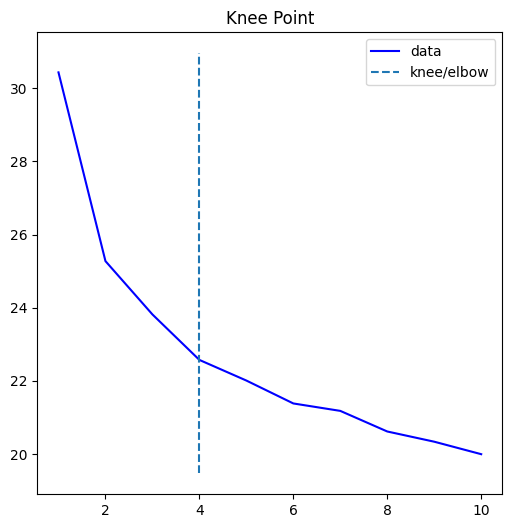

In [71]:
#Optimal number of clusters
nr_clusters_ = sse(val_set_)
#Clustering
w_NCOMO, cluster_NCOMO = optPort_nco(val_set_, min_matrix_, nr_clusters_, 0.074, 1000, 5, ret_clust = True)

Lets define some other benchmark portflios.

In [67]:
#EW
w_EW = np.ones(len(train_set.columns))
w_EW /= [len(train_set.columns)]*len(train_set.columns)
#MVO
w_MVO = optPortMVO(train_set)
#RPP
w_RPP = optPortRPP(train_set)

Not lets build the portfolios:

In [75]:
#building the single portfolios
port_NCOMO = Portfolio(f"NCO p = {pv}", test_set, w_NCOMO)
port_EWP = Portfolio("EWP", test_set, w_EW)
port_MVO = Portfolio("MVO", test_set, w_MVO)
port_RPP = Portfolio("RPP", test_set, w_RPP)
#comparing the portfolios
BM1 = PortfolioBenchmarking([port_NCOMO, port_EWP, port_MVO, port_RPP])

We are ready to perform some comparisons:

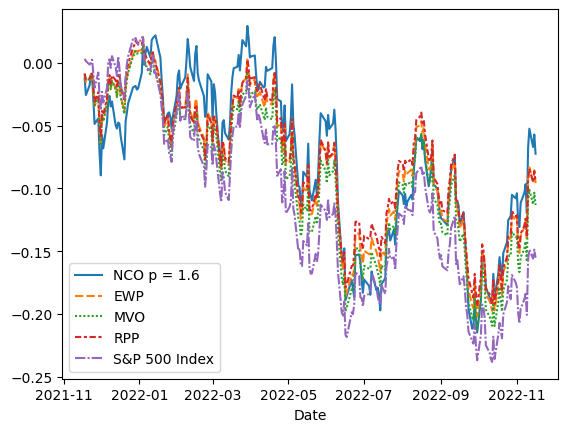

In [76]:
BM1.plot_performance()

In [77]:
BM1.performance_report()

/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
SPY,-0.1403,0.2408,0.0000,0.2817,1.0000,-0.5829,-0.9325,0.0000,-0.0753
NCO p = 1.6,-0.0366,0.2772,0.0005,0.3020,1.0592,-0.1321,-0.2151,0.9545,-0.0847
EWP,-0.0734,0.2334,0.0002,0.2506,0.9459,-0.3143,-0.5125,1.2649,-0.0722
MVO,-0.0924,0.2354,0.0002,0.4021,0.9558,-0.3925,-0.6432,0.9453,-0.0711
RPP,-0.0749,0.2221,0.0002,0.2911,0.9003,-0.3372,-0.5475,1.2143,-0.0694


In [79]:
BM1.cum_returns.corr()

,NCO p = 1.6,EWP,MVO,RPP,S&P 500 Index
NCO p = 1.6,1.000000,0.954917,0.941714,0.939202,0.894205
EWP,0.954917,1.000000,0.998506,0.998493,0.977505
MVO,0.941714,0.998506,1.000000,0.998361,0.986396
RPP,0.939202,0.998493,0.998361,1.000000,0.979822
S&P 500 Index,0.894205,0.977505,0.986396,0.979822,1.000000


##### 4.1.2 Cluster algorithm configurations

We will now compare different configurations of the NCO to see the impact of different inputs. First lets calculate again the different weights:

In [ ]:
# Investing just in a portfolio mean-variance optimized with the denoised and detoned correlation matrix
cov0 = corr2cov(corr2)
w_cov_only = optPortMVO(train_set, cov = cov0, cov_in = True)

# NCO with normal correlation matrix and omega opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_DO = optPort_nco(train_set, dist_matrix, 3, 0.5, 50, 5)

# NCO with minkowski distance matrix and sharpe opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_MS = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5, score = "sharpe")

# NCO with normal correlation matrix and sharpe opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_DS = optPort_nco(train_set, dist_matrix, 3, 0.5, 50, 5, score = "sharpe")

Let's build the portfolios

In [ ]:
# Correlation matrix only
port_COV = Portfolio("Denoised and Detoned", test_set, w_cov_only)
# Minkowski Omega
port_NCOMO = Portfolio("NCO Minkowski Omega", test_set, w_NCOMO)
# Minkowski Sharpe
port_NCOMS = Portfolio("NCO Minkowski Sharpe", test_set, w_NCO_MS)
# Correlation Omega
port_NCODO = Portfolio("NCO Correlation Omega", test_set, w_NCO_DO)
# Correlation Sharpe
port_NCODS = Portfolio("NCO Correlation Sharpe", test_set, w_NCO_DS)

# Combined
BM2 = PortfolioBenchmarking([port_COV, port_NCOMO, port_NCOMS, port_NCODO, port_NCODS])

Performance Comparison

In [ ]:
BM2.plot_performance()

##### 4.1.3 Long-Only vs. Long-Short

Lets get the portfolio weights

In [ ]:
# Long Only
w_NCOMO_LO = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5, constraint = "Long-Only")
#Long Short
w_NCOMO_LS = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5, constraint = "Long-Short")

Lets build the portfolio

In [ ]:
# Correlation matrix only
port_NCOMO_LO = Portfolio("NCO Long-Only", test_set, w_NCOMO_LO)
# Minkowski Omega
port_NCOMO_LS = Portfolio("NCO Long-Short", test_set, w_NCOMO_LS)

# Combined
BM3 = PortfolioBenchmarking([port_NCOMO_LS, port_NCOMO_LO])

Let compare

In [ ]:
BM3.plot_performance()

### 4.2. Robustness Analysis

##### 4.2.1 Time dimensioning

Let discover the effect of different train-test split layouts on the model performance. The are 2 parateter that we will explore. The ratio of train and test split and the overall sample size.

Train Test Ration

##### 4.2.2 Rebalacing

Let discover the effect of rebalacing on the porfolio performance.

In [ ]:
investment_start = test_set.index[0]
investment_start
# potfolio with rebalacing
ret_RB, clusters_RB = optPort_nco_RB(df, investment_start, 50, ret_clust = True)

In [ ]:
port_NCOMO_RB = Portfolio_Ret("NCO Monthly Rebalanced", ret_RB.iloc[:len(ret_RB)-1])

In [ ]:
bm4 = PortfolioBenchmarking([port_NCOMO_RB, port_NCOMO])

In [ ]:
bm4.plot_performance()

##### 4.2.3 Application in a different market environment

For compareable data we will use the components of the Jakarta Composite Index. 

In [ ]:
df_tyo = pd.read_csv("data/nikkei225comps.csv")
df_tyo = df_tyo.set_index("Date").pct_change().iloc[1:]
df_tyo.index = pd.to_datetime(df_tyo.index)

In [ ]:
train_set_tyo, test_set_tyo = testTrainSplit(df_tyo, validation_set = False, w_tt = [0.8, 0.2])

corr0_tyo = train_set_tyo.corr()#.fillna(0)

eVal0_tyo, eVec0_tyo, eVal1_tyo, eVec1_tyo, corr1_tyo, var0_tyo = denoiseMatrix(corr0_tyo)
corr2_tyo = detoneMatrix(corr1_tyo, eVal1_tyo, eVec1_tyo)

min_matrix_tyo = np.array(pairwise_distances(corr2_tyo, metric = "minkowski"))

In [ ]:
sse(min_matrix_tyo)

In [ ]:
w_tyo = optPort_nco(train_set_tyo, min_matrix_tyo, 3, 0.5, 500, 5)

In [ ]:
# Jakarta Composite NCO Optimized Port
tyo_port = Portfolio("NCO Nikkei225 Components", test_set_tyo[1:], w_tyo)
# Jakarta Composite Index
nikkei225_ret = pdr.get_data_yahoo(["^N225"], test_set_tyo.index[0], end)["Close"].pct_change()[1:len(test_set_tyo)]
nikkei225_ret = pd.Series(nikkei225_ret.values.reshape(-1), index = nikkei225_ret.index)
nikkei225_port = Portfolio_Ret("Nikkei225 Index", nikkei225_ret)

In [ ]:
BM5 = PortfolioBenchmarking([tyo_port,nikkei225_port])

In [ ]:
BM5.plot_performance(False)

## 5. Interpretatbility

#### 5.1 Cluster Analysis

##### 5.1.1 Cluster persistatance

We will take a look at the rebalanced portfolio and see whether the components of the clusters that found be the algorithm persist with time.

In [ ]:
def persistance_counter(clusters):
    nr_clusters = len(clusters[0])
    output = {}
    base_clusters = {}

    for i in range(nr_clusters):
        output[i] = []
        base_clusters[i] = np.array(clusters[0][i])

    for rb in clusters:
        cl = []
        for nr, cluster in rb.items():
            cl.append(cluster)
        for nr, cluster in rb.items():
            l = 0
            for c in cl:
                int = len(np.intersect1d(base_clusters[nr],np.array(c)))
                if int > l:
                    l = int
                else:
                    pass
            output[nr].append(l)
    return output

In [ ]:
pc = persistance_counter(clusters_RB)

In [ ]:
sns.lineplot(pd.DataFrame(pc), )

##### 5.1.2 Cluster Interpretation

In [ ]:
stock_finder = {}
for nr in range(len(df.columns)):
    stock_finder[nr] = df.columns[nr]
clusters_ticker = {}
for cl, stocks in cluster_NCOMO.items():
    clusters_ticker[cl] = []
    for stock in stocks:
        clusters_ticker[cl].append(stock_finder[stock])    
